In [4]:
import simpy
import random
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy import interpolate

import warnings

warnings.filterwarnings("ignore")

In [5]:
class ParkingLot(object):
    # Define the parking lot class 
    def __init__(self, env, number_of_spots):
        self.env = env
        self.spot = simpy.Resource(env, number_of_spots)

    def leave_spot(self, car):
        time = min(
            SIM_TIME - self.env.now,
            max(0, random.normalvariate(AVERAGE_STAY_TIME, STD_TIME_STAY)),
        )
        yield self.env.timeout(time)


def park(env, car, parking):
    global num_parked
    with parking.spot.request() as request:
        yield request
        num_parked += 1
        available_spots.append(num_parked)
        corresponding_time.append(env.now)
        yield env.process(parking.leave_spot(car))
        num_parked -= 1
        available_spots.append(num_parked)
        corresponding_time.append(env.now)


def run_parking(env, number_of_spots, enter_immediately, lamda_dist, time_interval):
    parking = ParkingLot(env, number_of_spots)
    for car in range(enter_immediately):
        env.process(park(env, car, parking))
    while True:
        env_now = int(env.now / 60 / time_interval)
        lamda = lamda_dist[env_now]
        time_til_new = np.random.exponential((1 / lamda) * 60 * time_interval)
        time_til_new_list.append(time_til_new)
        yield env.timeout(time_til_new)
        car += 1
        env.process(park(env, car, parking))

In [6]:
def lambda_distribution(lamda, len_open, time_interval):
    x = np.arange(len_open / time_interval)
    xp = np.linspace(0, len_open / time_interval, len(lamda))
    return np.interp(x, xp, lamda)


def map_times(times, start_hour):
    times_string = []
    start = datetime.datetime(year=1900, month=1, day=1, hour=start_hour)
    for time in times:
        delta_time = datetime.timedelta(minutes=int(time))
        current_time = start + delta_time
        current_time_string = current_time.strftime("%H:%M")
        times_string.append(current_time_string)
    return times_string

In [7]:
ponedeljak = np.array(
    [63, 97, 125, 150, 159, 154, 142, 152, 165, 201, 222, 203, 161, 107]
)
ponedeljak = lambda_distribution(ponedeljak, 14, 1 / 3600)
utorak = np.array([52, 74, 95, 112, 119, 123, 121, 127, 146, 177, 201, 188, 143, 95])
utorak = lambda_distribution(utorak, 14, 1 / 3600)
sreda = np.array([58, 73, 97, 109, 124, 121, 118, 120, 128, 149, 168, 161, 134, 87])
sreda = lambda_distribution(sreda, 14, 1 / 3600)
cetvrtak = np.array(
    [74, 102, 131, 147, 156, 151, 145, 143, 159, 182, 200, 186, 154, 97]
)
cetvrtak = lambda_distribution(cetvrtak, 14, 1 / 3600)
petak = np.array([59, 83, 106, 128, 141, 145, 142, 143, 152, 174, 196, 194, 155, 97])
petak = lambda_distribution(petak, 14, 1 / 3600)
subota = np.array([68, 109, 159, 197, 218, 212, 181, 158, 144, 155, 171, 162, 128, 85])
subota = lambda_distribution(subota, 14, 1 / 3600)
nedelja = np.array([62, 106, 150, 180, 193, 172, 153, 142, 160, 181, 183, 162, 114, 65])
nedelja = lambda_distribution(nedelja, 14, 1 / 3600)

broj_dolazaka_spic = 290
weights = np.vstack([ponedeljak, utorak, sreda, cetvrtak, petak, subota, nedelja])
weights = weights / weights.max()

In [8]:
days_of_the_week = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]

In [ ]:
# Defining the constants 
HOURS_OPEN = 14 #HOW LONG IS SHOP OPEN
NUMBER_OF_SPOTS = 1000000
ENTER_IMMIDIATELY = 5
AVERAGE_STAY_TIME = 25
STD_TIME_STAY = 3
TIME_INTERVAL = 1/60
SIM_TIME = HOURS_OPEN*60
num_parked = 0
base_rate = 290/60

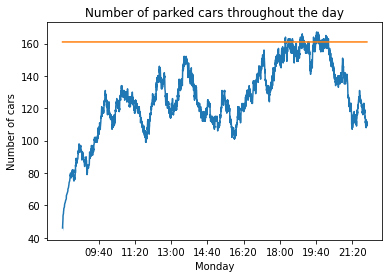

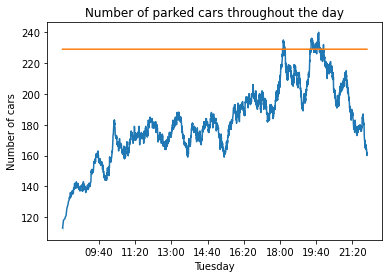

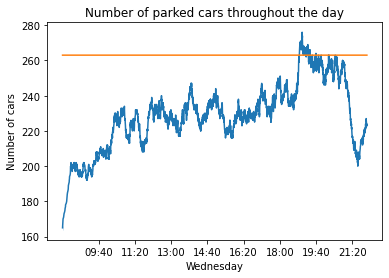

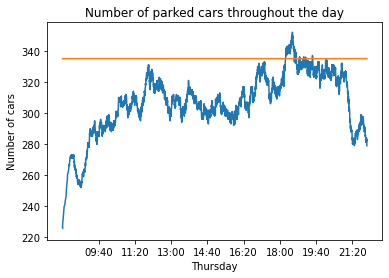

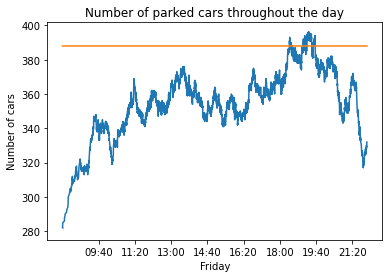

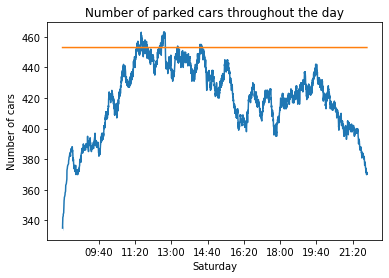

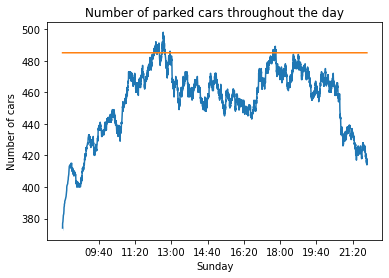

In [10]:
for day_of_the_week in range(7):

    available_spots = []
    corresponding_time = []
    time_til_new_list = []
    
    weight = weights[day_of_the_week]
    lamda = base_rate * weight
    l = lambda_distribution(lamda, HOURS_OPEN, TIME_INTERVAL)
    env = simpy.Environment()
    env.process(run_parking(env, NUMBER_OF_SPOTS, ENTER_IMMIDIATELY, l, TIME_INTERVAL))
    env.run(until = SIM_TIME)

    sns.lineplot(corresponding_time, available_spots)
    plt.plot(corresponding_time, np.full(shape = [len(corresponding_time)], fill_value=np.quantile(available_spots,0.95)))
    divided_ticks = 50

    
    # Mapping of the parkings 
    selected_times = [100,200,300,400,500,600,700,800]
    xlabels = map_times(selected_times, 8)
    plt.xticks(selected_times,xlabels, rotation = 0)
    plt.title('Number of parked cars throughout the day')
    plt.xlabel(days_of_the_week[day_of_the_week])
    plt.ylabel('Number of cars')
    plt.show()
